In [337]:
# Github Repository
# https://github.com/benduong1/Unsupervised-Machine-Learning-NMF-Endoscope-Repair-Level/upload
# Note that the data is not the same in the respoitory as my presentation due to the 25 mb limit on Github. My original data had 75 mbs

import pandas as pd
import nltk

#EDA and preprocessing
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits
import numpy as np

# Texting cleaning packages
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# Packages to create the word clouds
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier

In [338]:
# Loading the data
data = pd.read_excel("C:/Users/bendu/OneDrive/Desktop/Jupyter/V2 TRue Repair Workshop Analysis.xlsx", sheet_name = "KSEA All Data")

In [339]:
# Removing Columns that are not needed and would slowdown the model or give it unnecessary data
data = data.drop(columns = ['CUSTOMER', 'Customer Name', 'SERVICE ORDER', 'COMPLAINT #', 'SERIAL #', 'IMAGES', 'IMAGE1', 'IMAGE2', 'IMAGE3', 'IMAGE4', 
        'REVERSE LOOKUP EVALUATOR ', 'REVERSE LOOKUP DATE ', 'FILE COPY', 'MEAN TIME DAYS', 'Triggered Temp Dot', 'Fail on Focus Ring', 
        'Fail (Distel Tip)', 'Light Guide Voids', 'Total Marker Rings', 'Shaft Damage Over', 'Residue Vert', 'Suction Port', 
        'Fluid Invasion in Handle', 'Nicks connector/handle housing', 'Stain', 'Debris', 'Voids'])


In [340]:
# Function to clean the columns with columns
# Removing punctuation and filler words
def clean_text(dataframe, text_col):
    '''
    A helper function which takes a dataframe 
    and removes punction and stopwords.
    '''
    #remove all punctuation
    dataframe[text_col] = dataframe[text_col].astype(str) 
    
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    #remove stopwords
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #remove extra spaces
    dataframe[text_col] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))

    # removing the columns that were created
    dataframe = dataframe.drop(columns = ['no_punct', 'no_stopwords'])
    
    return 

In [341]:
# Looping through the columns to remove punctuation and filler words
clean_columns = ['CUSTOMER REASON 1', 'VISUAL INSPECTION COMMENT', 'LEAK TEST COMMENT', 'DEFLECTION COMMENT', 'TRACKING COMMENT', 
                 'EYE PIECE OPTICS COMMENT', 'PHOTO ADJUST COMMENT', 'IMAGE BUNDLE COMMENT', 'IMAGE QUALITY COMMENT', 
                 'LIGHT FIBERS COMMENT', 'LIGHT OUTPUT COMMENT', 'DISTAL LENS SYSTEM COMMENT', 'WORKING CHANNEL COMMENT', 
                 'CHANNEL PASSAGE COMMENT', 'CENTERING COMMENT', 'SHAFT COMMENT', 'DISTAL TIP COMMENT', 'VERTEBRAE SYSTEM COMMENT', 
                 'ANGLE COVER COMMENT', 'SUCTION/IRRIGATION COMMENT', 'PRIMARY DAMAGE TYPE DESC', 'DETAILS', 'TERMINAL   DAMAGE LOC DESC', 
                 'TERMINAL   DAMAGE TYPE DESC', 'TERMINAL  DAMAGE CAUSE DESC']

for column in clean_columns:
    clean_text(data, column)
    

In [342]:
# Removing the 'Simple Repair Level' column values with '?'
# This is because ? represents a repair level that is unknown or not needed so it would create noise in the data
data = data[data['Simple Repair Level'] != '?']
data = data[data['Simple Repair Level'] != 'Goodwill']
data = data[data['Simple Repair Level'] != 'Service Cost']

In [343]:
# Creating a copy of the data to make it easier to redo if I make a mistake
data_model = data

In [344]:
# Creating a column that combines all the comments
data_model['Combined Comments'] = data_model[['CUSTOMER REASON 1', 'VISUAL INSPECTION COMMENT' , 'LEAK TEST COMMENT' , 'DEFLECTION COMMENT' , 'TRACKING COMMENT' , 
                   'EYE PIECE OPTICS COMMENT' , 'PHOTO ADJUST COMMENT' , 'IMAGE BUNDLE COMMENT' , 'IMAGE QUALITY COMMENT' , 
                   'LIGHT FIBERS COMMENT' , 'LIGHT OUTPUT COMMENT' , 'DISTAL LENS SYSTEM COMMENT' , 'WORKING CHANNEL COMMENT' , 
                   'CHANNEL PASSAGE COMMENT' , 'CENTERING COMMENT' , 'SHAFT COMMENT' , 'DISTAL TIP COMMENT' , 'VERTEBRAE SYSTEM COMMENT' , 
                   'ANGLE COVER COMMENT' , 'SUCTION/IRRIGATION COMMENT' , 'PRIMARY DAMAGE LOC DESC' , 'PRIMARY DAMAGE TYPE DESC' , 'DETAILS' , 
                   'PRIMARY DAMAGE CAUSE DESC' , 'TERMINAL   DAMAGE LOC DESC' , 'TERMINAL   DAMAGE TYPE DESC' , 'TERMINAL  DAMAGE CAUSE DESC' , 
                   'Value Stream' , 'Model Category']].agg(' '.join, axis = 1)

EDA

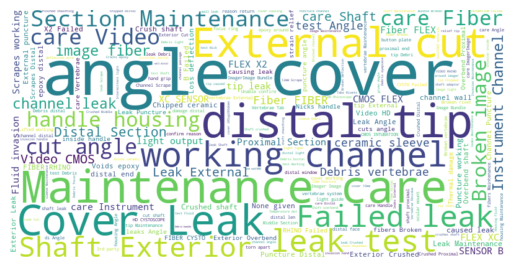

In [347]:
# Creating a word graph of the words used for all comments
all_comments = ' '.join(data_model['Combined Comments'])

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white', 
    stopwords=STOPWORDS
).generate(all_comments)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

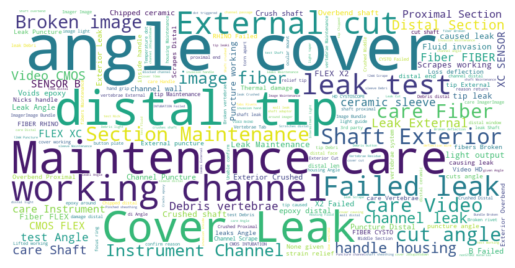

In [349]:
# Creating a word graph of the words used for major comments
high_comments = ' '.join(data_model['Combined Comments'][data_model['Simple Repair Level'] == 'High'])

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white', 
    stopwords=STOPWORDS
).generate(high_comments)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

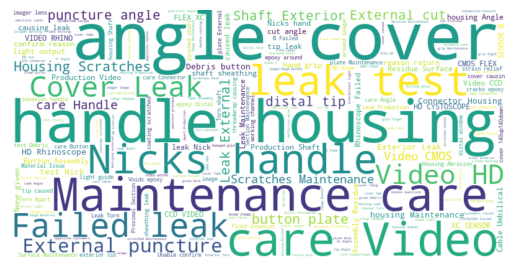

In [350]:
# Creating a word graph of the words used for Medium comments
medium_comments = ' '.join(data_model['Combined Comments'][data_model['Simple Repair Level'] == 'Medium'])

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white', 
    stopwords=STOPWORDS
).generate(medium_comments)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

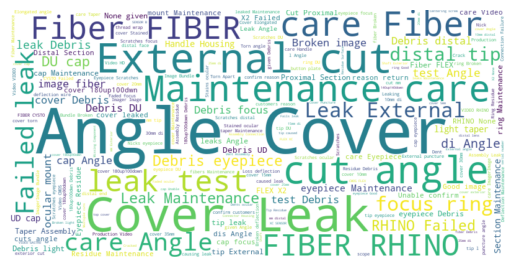

In [351]:
# Creating a word graph of the words used for Low comments
low_comments = ' '.join(data_model['Combined Comments'][data_model['Simple Repair Level'] == 'Low'])

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white', 
    stopwords=STOPWORDS
).generate(low_comments)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

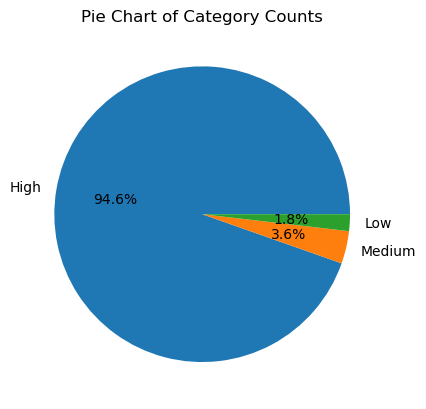

In [352]:
# Creating a pie chart to show the distribution of repair levels
# Count the values in the column
value_counts = data_model['Simple Repair Level'].value_counts()

# Create the pie chart
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Pie Chart of Category Counts')
plt.show()

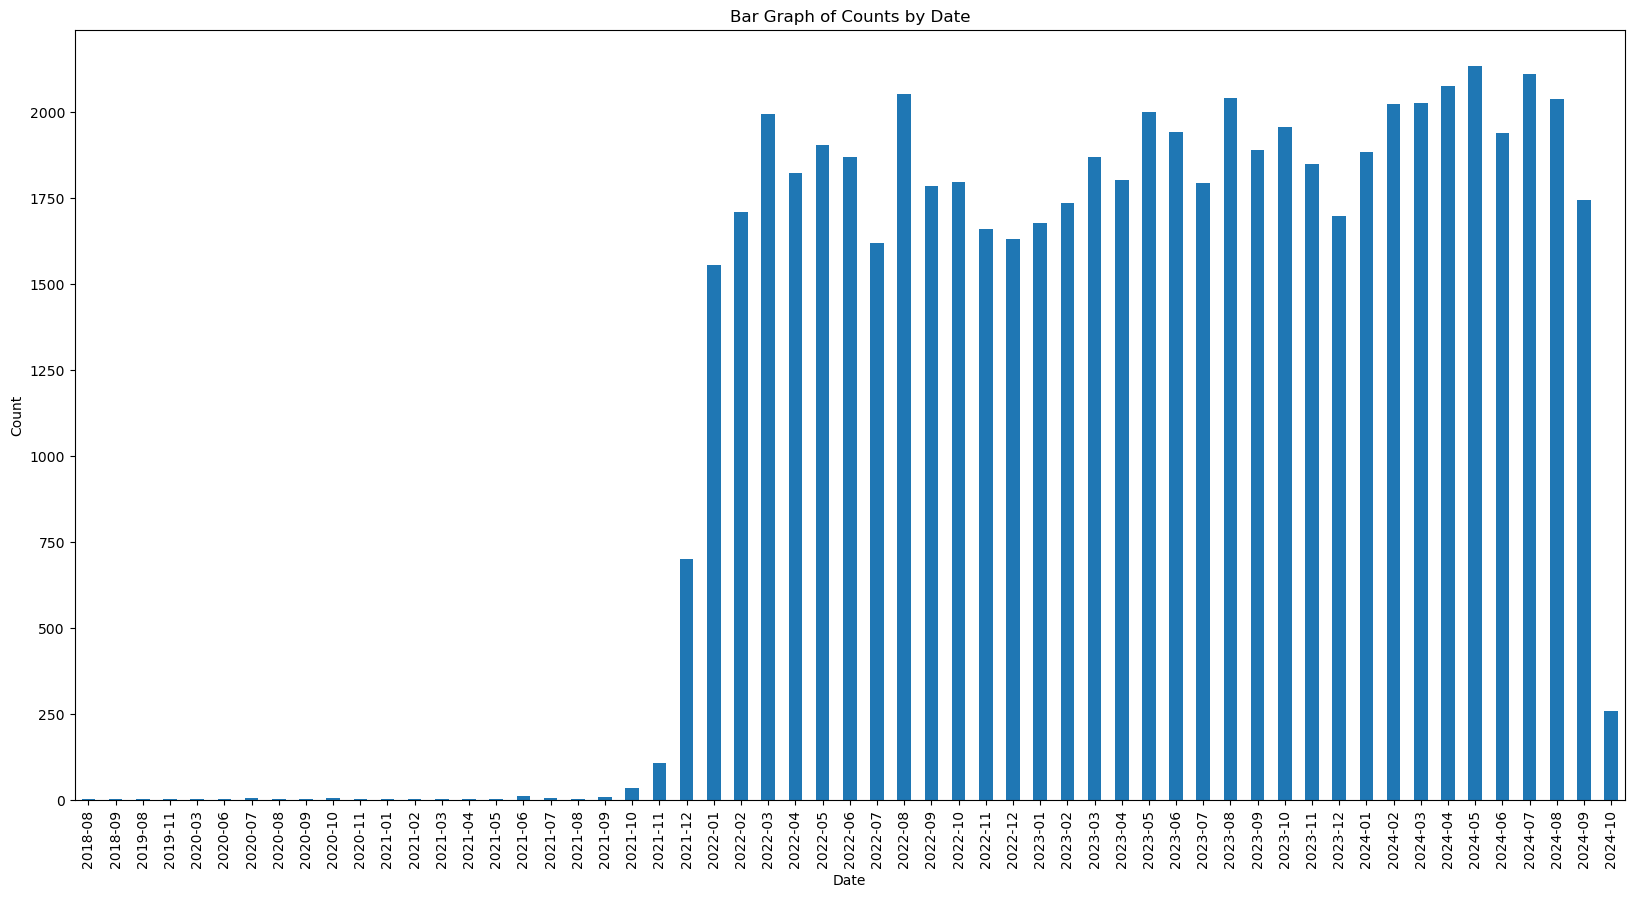

In [353]:
# Creating a repair count over time using RMA DATE

# Converting the data into a date format
data_model['RMA DATE'] = pd.to_datetime(data_model['RMA DATE'])

data_model['month_year'] = pd.to_datetime(data_model['RMA DATE']).dt.strftime('%Y-%m')  # Create a new column with month-year format

grouped_data = data_model.groupby('month_year').size().reset_index(name='count') 

date_counts = data_model.groupby('month_year').size()

# Create bar plot
date_counts.plot(kind='bar', figsize = (20, 10))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Bar Graph of Counts by Date')
plt.show()

End of EDA

In [355]:
# Now that the data is cleaned up I will break it up into a train (70%) and test (30%) sets

# Creating the labels array for what the repair were actually coded as
labels = data_model['Simple Repair Level']


In [356]:
# splitting up the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_model, labels, test_size=0.3, random_state=42)

In [357]:
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    repair = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        repair[i] = predictions[i][0]
    return repair

In [358]:
def label_permute(ytdf,yp,n=3):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    perms = list(itertools.permutations([0, 1, 2]))    #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['High', 'Medium', 'Low']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 3:
                conditions = [
                    (ytdf['Simple Repair Level'] == current['High']),
                    (ytdf['Simple Repair Level'] == current['Medium']),
                    (ytdf['Simple Repair Level'] == current['Low'])]
                ytdf['test'] = ytdf['Simple Repair Level'].map(current)
                current_accuracy = accuracy_score(ytdf['test'], yp)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    ytdf['best'] = ytdf['test']
    return best_labels, best_acc

In [359]:
# Vectorizing the comment column
tfidvec = TfidfVectorizer(
    max_df=0.7,
    min_df=0.01,
    ngram_range=(1, 2),
    max_features=700,
    use_idf=True)

In [423]:
tfidvec_train = tfidvec.fit_transform(X_train['Combined Comments'])

# Create model
nmf_model =NMF(n_components = 3,
               init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                max_iter = 500,
                random_state = 101)

In [424]:
# Run model on the comment matrix
nmf_model.fit(tfidvec_train)

NMF(beta_loss='kullback-leibler', init='nndsvda', l1_ratio=0.5, max_iter=500,
    n_components=3, random_state=101, solver='mu')

In [426]:
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(X_train, yhat_train)

print("train accuracy = ", accuracy)

train accuracy =  0.3759643174111918


Checking to see how well this performs on the test data

In [429]:
tfidvec_test = tfidvec.fit_transform(X_test['Combined Comments'])

In [430]:
yhat_test = predict(nmf_model.transform(tfidvec_test))
label_order, accuracy = label_permute(X_test, yhat_test)

print("test accuracy = ", accuracy)

test accuracy =  0.5766167569289583
